In [1]:
import torch
import matplotlib.pyplot as plt
from ImageDataset import ImageSet, DeviceDataLoader
from model import DeepLabv3, DeepLabv3_plus
from trainers import fit
from loss import CrossEntropyLoss

In [2]:
loss = CrossEntropyLoss()
model = DeepLabv3(2)
if torch.cuda.is_available():
    model.cuda()

In [3]:
image_dir = "data/images"
label_dir = "data/labels/person"

MyPeopleSet = ImageSet(image_dir, label_dir)

# Set the seed for the random split
torch.manual_seed(42)

train, val, test = torch.utils.data.random_split(MyPeopleSet, (0.5, 0.1, 0.4))
train_loader = DeviceDataLoader(train, batch_size=8, shuffle=True)
val_loader = DeviceDataLoader(val, batch_size=8, shuffle=False)
test_loader = DeviceDataLoader(test, batch_size=1, shuffle=False)

Loading Images: 0001.jpg, ..., 0600.jpg
Loading Labels: 0001_person.png, ..., 0600_person.png


In [4]:
# fit(
#     25,
#     torch.optim.Adam,
#     model,
#     loss,
#     0.00005,
#     train_loader,
#     val_loader,
#     torch.optim.lr_scheduler.ReduceLROnPlateau,
# )

In [5]:
best_model = torch.load("saved_models/DeepLabv3_2.pt")
best_model.eval()

DeepLabv3(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, ker

In [6]:
def calculate_accuracy(model, test_loader):
    """Calculate the accuracy of the model on the test set."""
    correct_pixels = 0
    total_pixels = 0

    for idx, images, labels in test_loader:
        with torch.no_grad():
            predicted_masks = model(images)
            predicted_masks = torch.argmax(predicted_masks, dim=1)
            correct_pixels += torch.sum(predicted_masks == labels).item()
            total_pixels += torch.numel(labels)

    return correct_pixels / total_pixels


accuracy = calculate_accuracy(best_model, test_loader)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.9847307986111111


In [7]:
def calculate_iou(predicted_masks, labels, num_classes):
    """Calculate Intersection over Union (IoU) for each class."""
    iou_per_class = torch.zeros(num_classes)
    for cls in range(num_classes):
        intersection = torch.sum((predicted_masks == cls) & (labels == cls))
        union = torch.sum((predicted_masks == cls) | (labels == cls))
        if union != 0:
            iou_per_class[cls] = intersection.float() / union
    return iou_per_class


def calculate_mean_iou(model, test_loader, num_classes):
    """Calculate the mean Intersection over Union (IoU) of the model on the test set."""
    total_iou = torch.zeros(num_classes)
    total_samples = 0

    for idx, images, labels in test_loader:
        with torch.no_grad():
            predicted_masks = model(images)
            predicted_masks = torch.argmax(predicted_masks, dim=1)
            total_iou += calculate_iou(predicted_masks, labels, num_classes)
            total_samples += images.size(0)

    mean_iou = torch.mean(total_iou / total_samples)
    return mean_iou


mean_iou = calculate_mean_iou(best_model, test_loader, 2)
print(f"Mean IoU: {mean_iou}")

Mean IoU: 0.9575167298316956


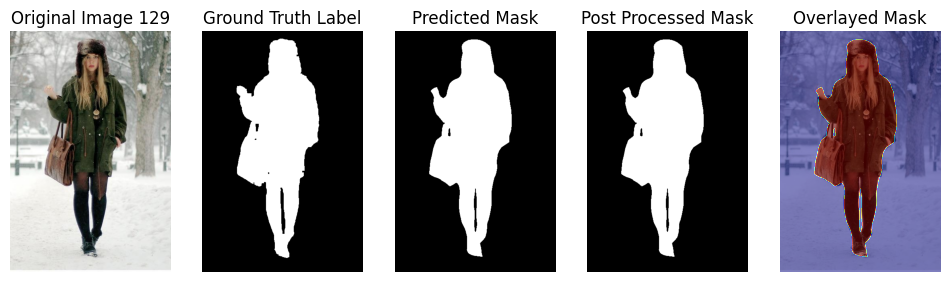

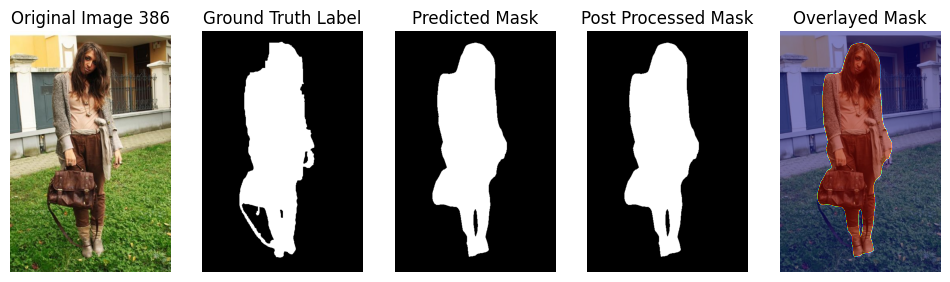

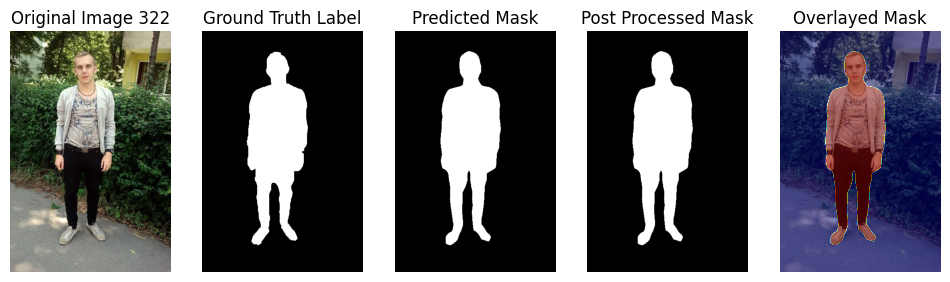

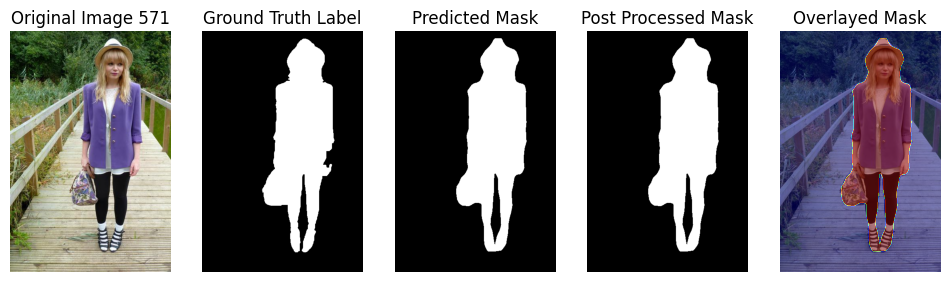

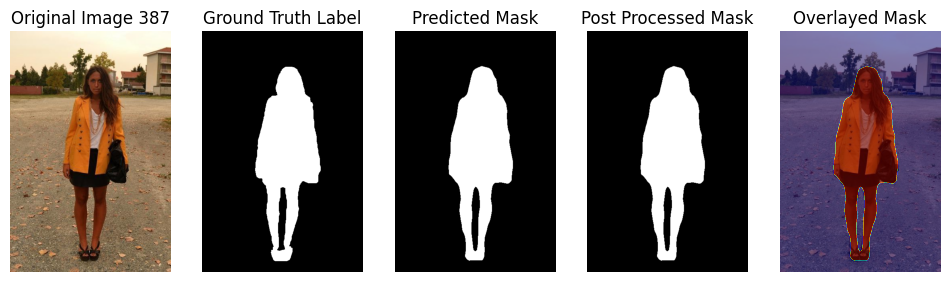

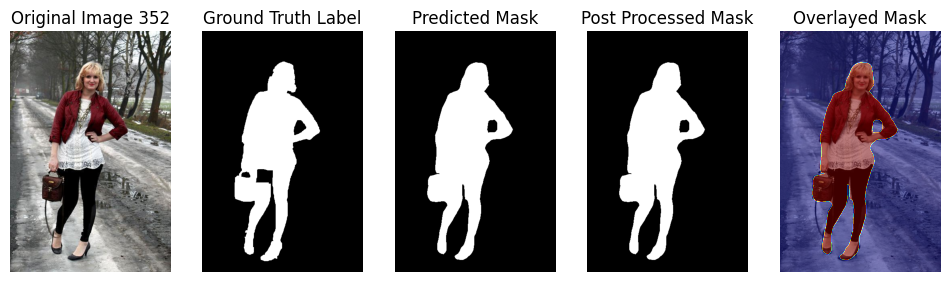

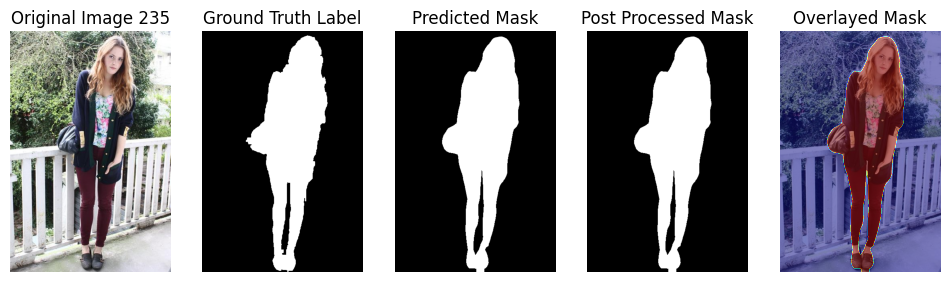

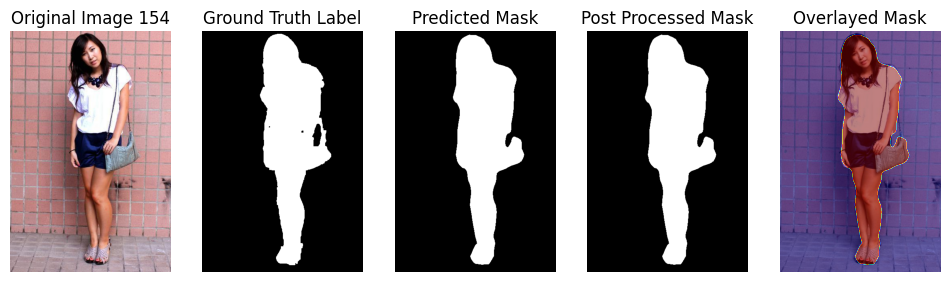

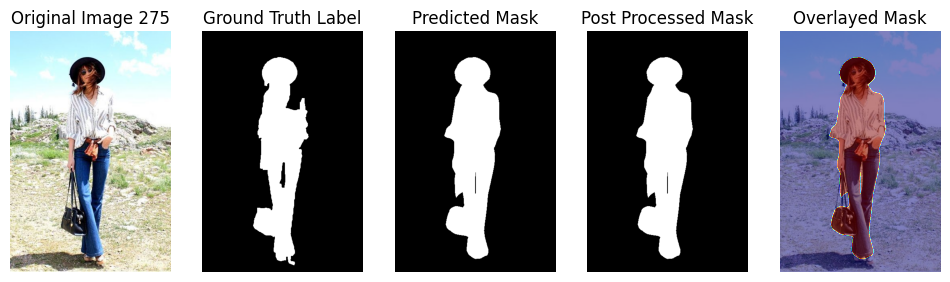

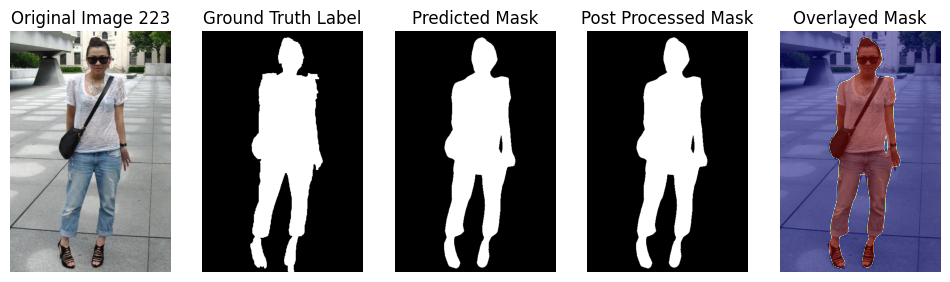

In [8]:
import matplotlib.image
from utils import remove_small_artifacts, to_tensor, to_tensor_lab

output_range = range(10)

# Plot some of the samples
for i, (idx, image, label) in enumerate(test_loader):
    if i not in output_range:
        break

    with torch.no_grad():
        pred_mask = best_model(image)

    # Convert the predicted mask and label to numpy arrays
    pred_mask = pred_mask.argmax(dim=1).cpu().numpy()[0]

    gt_label = label.squeeze(1).cpu().numpy()[0]

    # Plot the original image
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 5, 1)
    plt.imshow(MyPeopleSet.images[idx])
    plt.title(f"Original Image {idx[0] + 1}")
    plt.axis("off")

    # Plot the ground truth label
    plt.subplot(1, 5, 2)
    plt.imshow(gt_label, cmap="gray")
    plt.title("Ground Truth Label")
    plt.axis("off")

    # Plot the predicted mask
    plt.subplot(1, 5, 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    post_process = remove_small_artifacts(pred_mask)

    plt.subplot(1, 5, 4)
    plt.imshow(post_process, cmap="gray")
    plt.title("Post Processed Mask")
    plt.axis("off")

    # Plot the predicted mask overlaid on the original image
    plt.subplot(1, 5, 5)
    plt.imshow(MyPeopleSet.images[idx])
    plt.imshow(post_process, cmap="jet", alpha=0.5)
    plt.title("Overlayed Mask")
    plt.axis("off")
    plt.show()

    # matplotlib.image.imsave(f'data/output/mask_{(index+1):04d}.png', post_process)

In [9]:
# I did experiments with different models.
# This model behaves better than others and has the shortest training time.
# See some of the test result samples above.
# When I am making a web app, I could be conservative and allow the users to add additional features (dialation, erosion, etc.) to fine-tune the results.
# Additionally, I have tried to add random transformations to the images when training, but I have observed lower test accuracy, ~0.5–1% lower.
# Mask RCNN is a good model for this task, but it is computationally expensive.
# I thought about using pose detection; however, since bags and other objects are sometimes counted in the labels, this solution may not work.

# Instead of using the post-processing function, I could use a Condintional Random Field to remove small artifacts.

# I tried initializing the weights in certain layers but only really saw improvement in the RESNET layers.

# The challenge with clothing is that one singular component may be counted as multiple segmented labels.

# Future work to improve the crf layer (currently online solutions for pytorch permutohedral operations breaking)

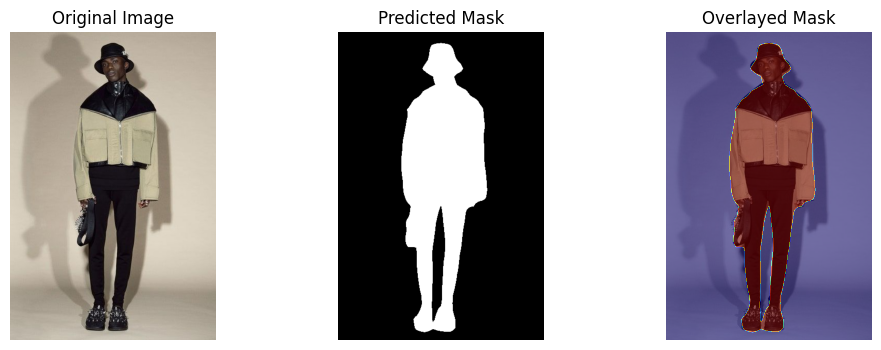

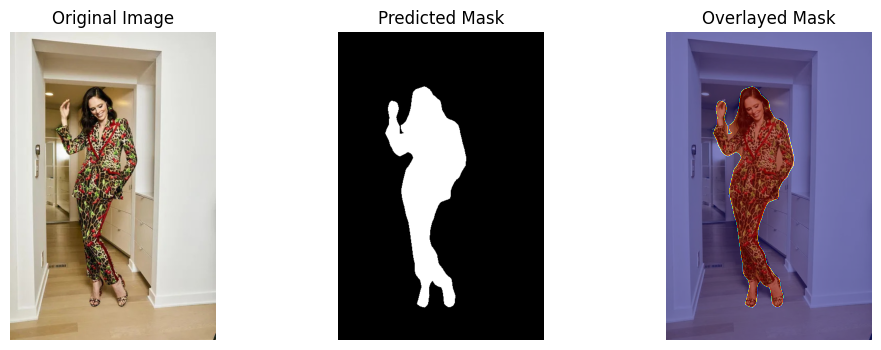

In [10]:
# I would like to test the model on some images outside the dataset to see how well it generalizes
import cv2

# Images outside the dataset 0
image = cv2.imread("data/test_0.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_tensor = to_tensor_lab(image)
pred_mask = best_model(image_tensor.cuda())

pred_mask = pred_mask.argmax(dim=1).cpu().numpy()[0]
pred_mask = remove_small_artifacts(pred_mask)

# Original image
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title(f"Original Image")
plt.axis("off")

# Predicted mask
plt.subplot(1, 3, 2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

# Predicted mask overlaid on the original image
plt.subplot(1, 3, 3)
plt.imshow(image)
plt.imshow(pred_mask, cmap="jet", alpha=0.5)
plt.title("Overlayed Mask")
plt.axis("off")
plt.show()

# Images outside the dataset 1
image = cv2.imread("data/test_1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_tensor = to_tensor_lab(image)

pred_mask = best_model(image_tensor.cuda())

pred_mask = pred_mask.argmax(dim=1).cpu().numpy()[0]
pred_mask = remove_small_artifacts(pred_mask)

# Original image
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title(f"Original Image")
plt.axis("off")

# Predicted mask
plt.subplot(1, 3, 2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

# Predicted mask overlaid on the original image
plt.subplot(1, 3, 3)
plt.imshow(image)
plt.imshow(pred_mask, cmap="jet", alpha=0.5)
plt.title("Overlayed Mask")
plt.axis("off")
plt.show()

Loading Images: 0001.jpg, ..., 0600.jpg
Loading Labels: 0001_clothes.png, ..., 0600_clothes.png
Mean IoU: 0.5424606204032898
Test Accuracy: 0.9417918229166666


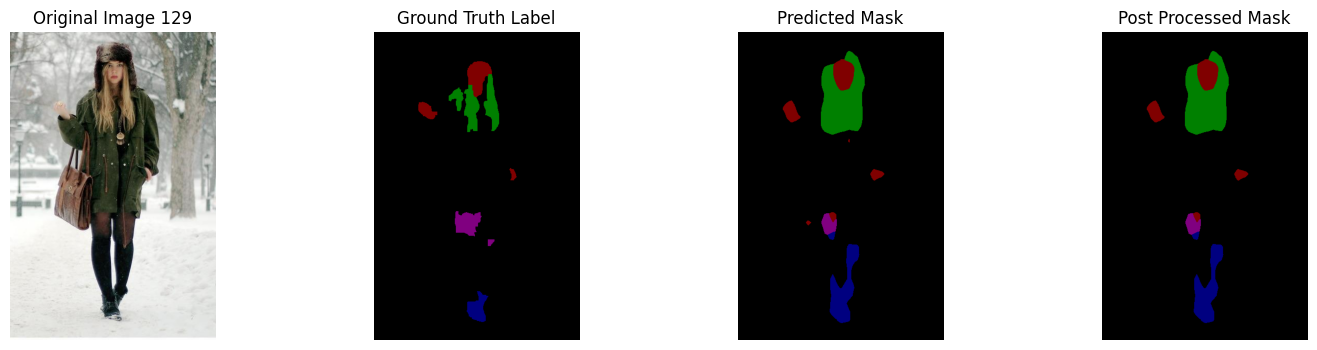

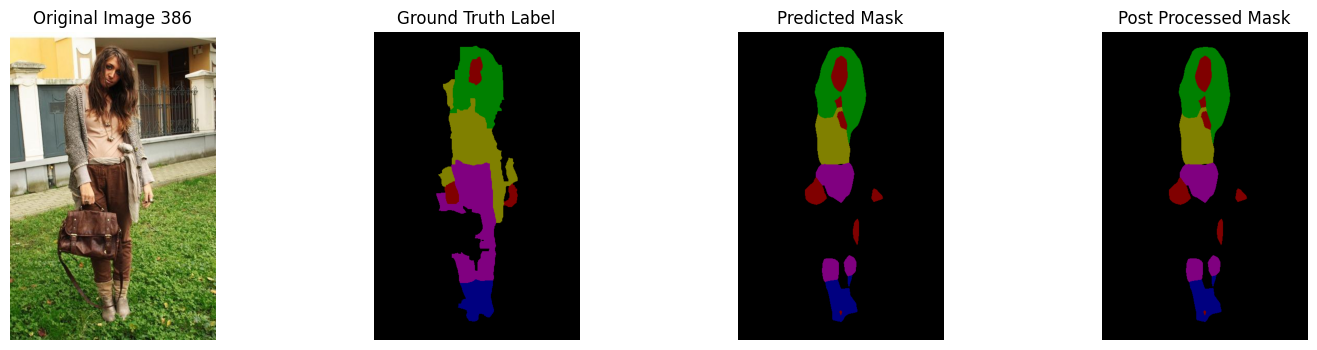

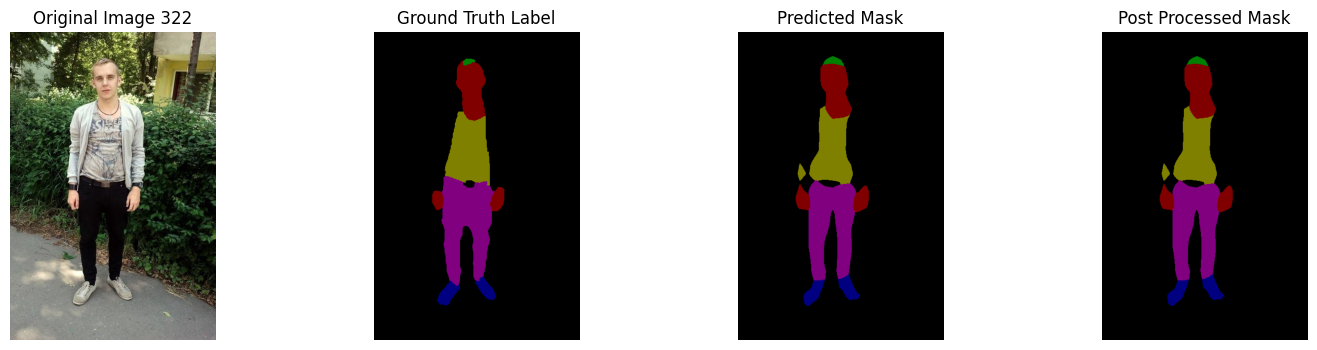

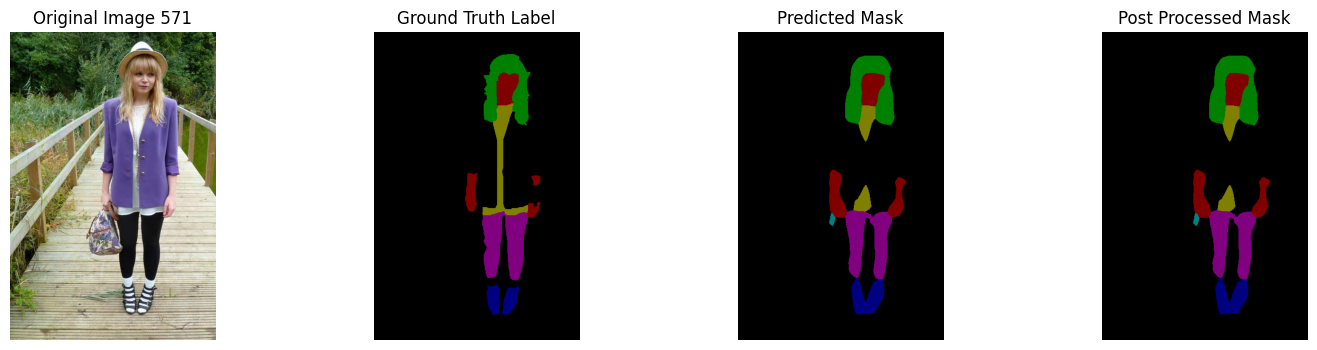

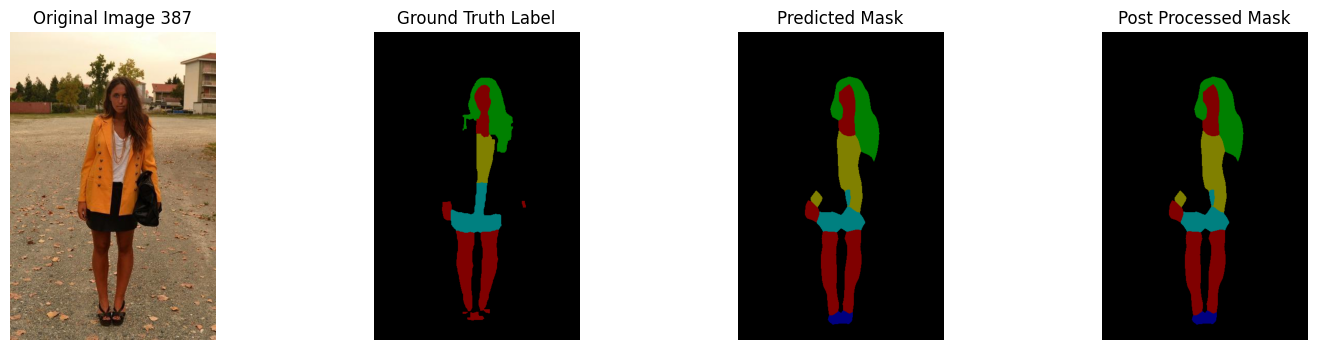

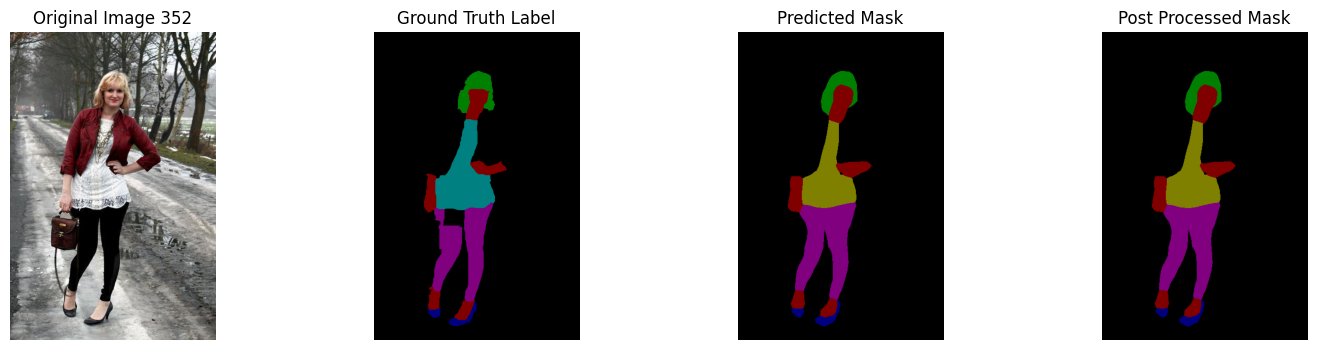

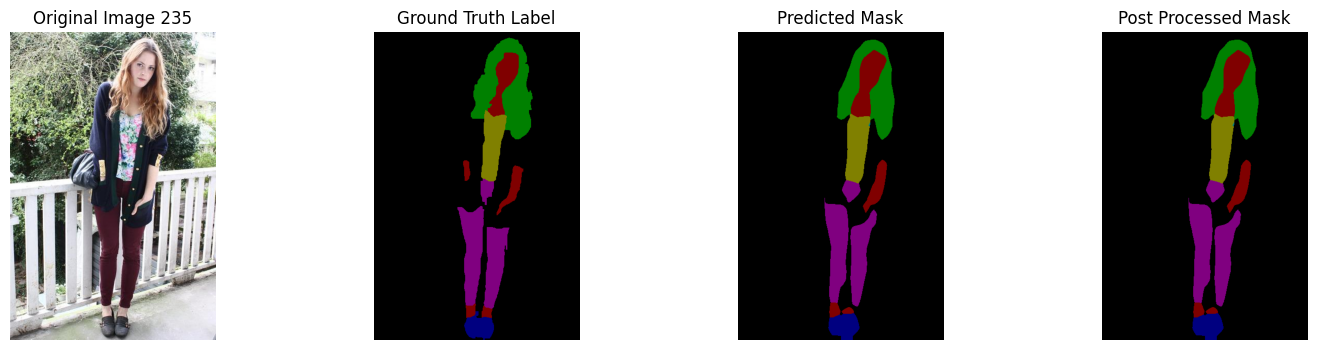

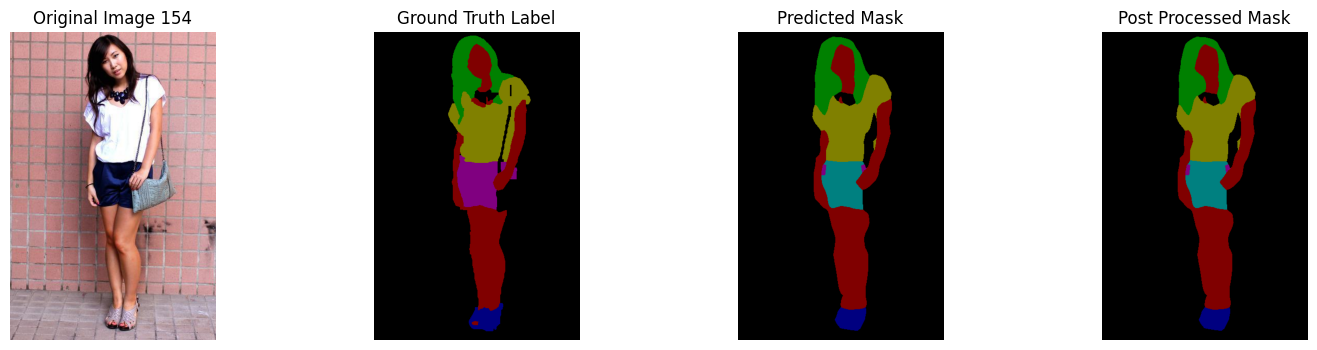

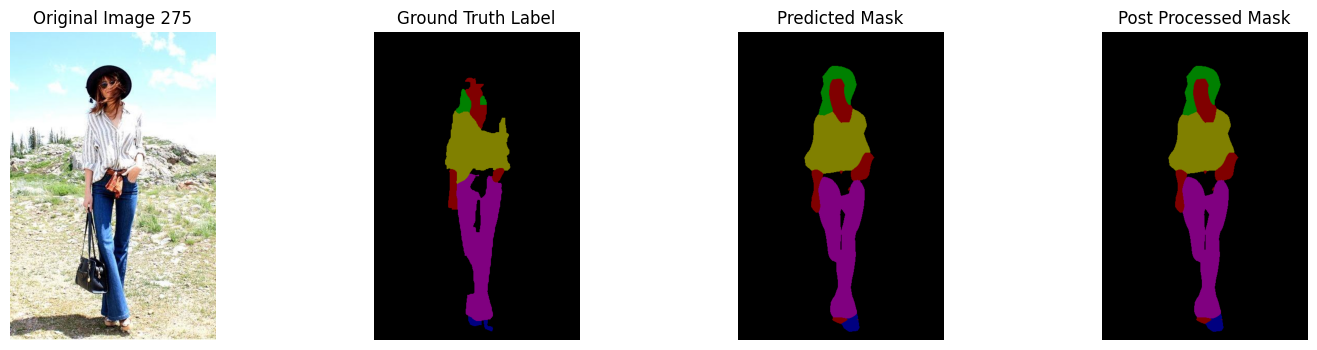

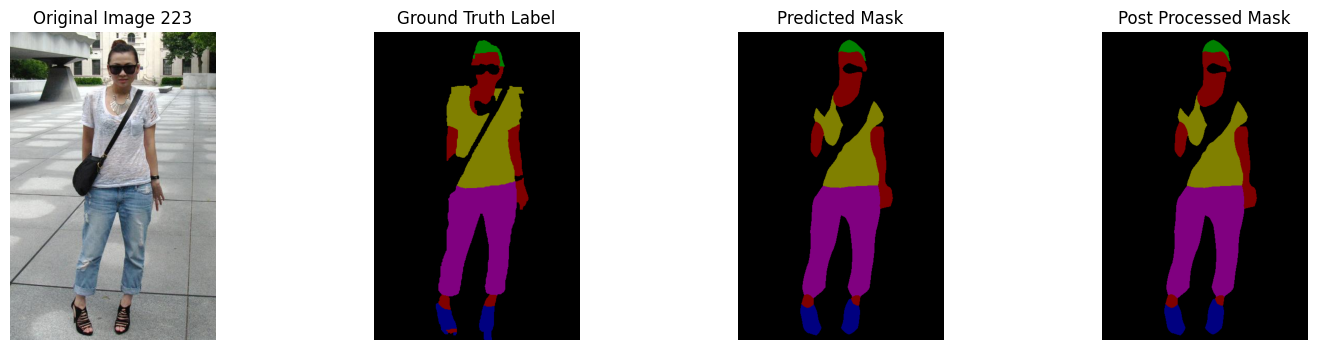

In [11]:
import torch
import matplotlib.pyplot as plt
from ImageDataset import ImageSet, DeviceDataLoader
from model import DeepLabv3
from trainers import fit
from loss import WeightedCrossEntropyLoss
import numpy as np

image_dir = "data/images"
label_dir = "data/labels/clothes"

MyPeopleSet = ImageSet(image_dir, label_dir, label_type="multi")

# Set the seed for the random split
torch.manual_seed(42)
train, val, test = torch.utils.data.random_split(MyPeopleSet, (0.5, 0.1, 0.4))
train_loader = DeviceDataLoader(train, batch_size=8, shuffle=True)
val_loader = DeviceDataLoader(val, batch_size=8, shuffle=False)
test_loader = DeviceDataLoader(test, batch_size=1, shuffle=False)


loss = WeightedCrossEntropyLoss([1, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5])
model = DeepLabv3(7)
if torch.cuda.is_available():
    model.cuda()

# fit(
#     30,
#     torch.optim.Adam,
#     model,
#     loss,
#     0.00005,
#     train_loader,
#     val_loader,
#     torch.optim.lr_scheduler.ReduceLROnPlateau,
# )

best_model = torch.load("saved_models/DeepLabv3_7.pt")
best_model.eval()

mean_iou = calculate_mean_iou(best_model, test_loader, 7)
print(f"Mean IoU: {mean_iou}")

accuracy = calculate_accuracy(best_model, test_loader)
print(f"Test Accuracy: {accuracy}")

from utils import remove_small_artifacts

inverse_color_map = {
    0: np.array((0, 0, 0)),  # background
    1: np.array((128, 0, 0)),  # skin
    2: np.array((0, 128, 0)),  # hair
    3: np.array((128, 128, 0)),  # tshirt
    4: np.array((0, 0, 128)),  # shoes
    5: np.array((128, 0, 128)),  # pants
    6: np.array((0, 128, 128)),  # dress
}

output_range = range(10)

# Plot some of the samples
for i, (idx, image, label) in enumerate(test_loader):
    if i not in output_range:
        break

    with torch.no_grad():
        pred_mask = best_model(image)

    # Convert the predicted mask and label to numpy arrays
    pred_mask = pred_mask.argmax(dim=1).cpu().numpy()[0]
    gt_label = label.squeeze(1).cpu().numpy()[0]
    post_process = remove_small_artifacts(pred_mask, min_size=100)

    # Map back the colors to original pallette
    pred_mask_color = np.zeros(
        (pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8
    )
    gt_label_color = np.zeros((gt_label.shape[0], gt_label.shape[1], 3), dtype=np.uint8)
    post_process_color = np.zeros(
        (post_process.shape[0], post_process.shape[1], 3), dtype=np.uint8
    )

    for class_idx, color in inverse_color_map.items():
        pred_mask_color[pred_mask == class_idx] = color
        gt_label_color[gt_label == class_idx] = color
        post_process_color[post_process == class_idx] = color

    # Plot the original image and masks
    plt.figure(figsize=(18, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(MyPeopleSet.images[idx])
    plt.title(f"Original Image {idx[0] + 1}")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(gt_label_color)
    plt.title("Ground Truth Label")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask_color)
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(post_process_color)
    plt.title("Post Processed Mask")
    plt.axis("off")
    plt.show()